In [143]:
import boto3
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

from sklearn.model_selection import train_test_split

role = get_execution_role()
bucket='hack4med'

przyjecie_file = 'CRACoV-PRZYJECIE.csv'
biochemia_file = 'CRACoV-BIOCHEMIA_3.csv'
echo_file = 'CRACoV-ECHO.csv'
nefro_file = '_CRACoV-NEFRO.csv'
mapowanie_tomografii_file = 'CRACoV-MAPOWANIE-TOMOGRAFII.csv'
radio_file = 'CRACoV-RADIO.csv'
etykiety_file = 'CRACoV-ETYKIETY.csv'

def load_csv(file, skiprows=0):
    data_location = 's3://{}/{}'.format(bucket, file)
    return pd.read_csv(data_location, skiprows=skiprows)

# tutaj mamy wszystkie wczytane dane
przyjecia = load_csv(przyjecie_file)
biochemia = load_csv(biochemia_file)
echo = load_csv(echo_file)
# nefro ma zwalony pierwszy wiersz
nefro = load_csv(nefro_file, 1)
mapowanie_tomografii = load_csv(mapowanie_tomografii_file)
radio = load_csv(radio_file)
etykiety = load_csv(etykiety_file)

def clean_data(df):
    df = df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
    
    df = df.replace('nie', 0)
    df = df.replace('nie wiadomo', 1)
    df = df.replace('tak', 2)
    
    df = df.replace('covid', 1)
    df = df.replace('inny (współistniejący covid)', 1)
    
    df = df.fillna(0)
    return df

def lpAndidLabToInt(df):
    return df.astype({"LP.": int, "ID_LAB": int})

def createId(df):
    df["ID"] = df["LP."] + 100000*df["ID_LAB"]
    df = df.astype({"ID": int})
    df.drop('LP.', inplace=True, axis=1)
    df.drop('ID_LAB', inplace=True, axis=1)
    return df

def load_and_parse(file):
    df = load_csv(file)
    df = clean_data(df)
    df = lpAndidLabToInt(df)
    df = createId(df)
    return df





def load_przyjecia():
    df = load_and_parse(przyjecie_file)
    df = df.astype({"WIEK": int, "PRZENIESIENIE": int, "HOSP_PRZYCZ": int, "NT": int, "DM": int, "ASTMA": int, "POCHP": int, "HF": int, "AF": int, "UDAR": int, "CHD": int, "MI": int, "ZAP_PLUC": int, "PCHN": int, "DEKSAMETEZON": int, "HDCZ": int, "BB": int, "STATYNA": int, "ASA": int, "NOAC": int, "MRA": int, "ACE": int, "SARTANY": int, "CA_BLOKER": int})
    df = df.filter(items=['ID', 'PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER'])
    return df

def load_biochemia():
    df = load_and_parse(biochemia_file)
    df = df.filter(items=['ID', 'KOD', 'WYNIK'])
    df = df.drop_duplicates(subset=['ID', 'KOD'], keep='last')
    df = df.pivot(index="ID", columns="KOD", values="WYNIK")
    df = df.applymap(lambda x: x.replace('<', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace('>', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(' mg/l', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df


def load_echo():
    df = load_and_parse(echo_file)
    return df

# def load_nefro():
#     return load_csv(nefro_file, 1)

def load_mapowanie_tomografii():
    df = load_and_parse(mapowanie_tomografii_file)
    return df


def load_radio():
    df = load_and_parse(radio_file)
    return df


def load_etykiety():
    df = load_and_parse(etykiety_file)
    return df



def all_data():
    joined = pd.merge(load_przyjecia(), load_biochemia(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_echo(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_mapowanie_tomografii(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_radio(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_etykiety(), on=["ID"], how='outer')
    joined = joined.fillna(0)
    return joined


(500, 34)


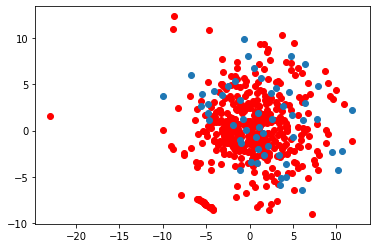

In [21]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# labels_in_data = ['ZGON_LUB_OIT', 'PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER', 'n58.11.11342_pct', 'i81.11.1112_crp', 'g49.122.1113_dd', 'm05_il-6', 'o59_tnhs', 'n11.126.20.1cito_mlecz', 'm37.11.191_krea', 'c55.103.02_wbc', 'c55.103.02_plt']
# labels_in_data = ['PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER', 'n58.11.11342_pct', 'i81.11.1112_crp', 'g49.122.1113_dd', 'm05_il-6', 'o59_tnhs', 'n11.126.20.1cito_mlecz', 'm37.11.191_krea', 'c55.103.02_wbc', 'c55.103.02_plt']
labels_in_data = ['PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER']
data = all_data().filter(labels_in_data + ['ZGON_LUB_OIT'])

data[labels_in_data]=(data[labels_in_data] - data[labels_in_data].mean()) / data[labels_in_data].std()

for header in labels_in_data:
    data = data.astype({header: np.float32})

# for x in ['ZAP_PLUC', 'WIEK', 'WZROST', 'NT', 'WZROST', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'n58.11.11342_pct', 'i81.11.1112_crp', 'g49.122.1113_dd', 'm05_il-6', 'o59_tnhs', 'n11.126.20.1cito_mlecz', 'm37.11.191_krea', 'c55.103.02_wbc', 'c55.103.02_plt']:
#     data[x] = data[x]/data[x].mean()
    
    
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[labels_in_data],)
>>> kmeans.labels_
array([1, 1, 1, 0, 0, 0], dtype=int32)
>>> kmeans.predict([[0, 0], [12, 3]])
array([1, 0], dtype=int32)
>>> kmeans.cluster_centers_
array([[10.,  2.],
       [ 1.,  2.]])
    
print(data.shape)

embedding = MDS(n_components=2)
datax = embedding.fit_transform(data[labels_in_data], data['ZGON_LUB_OIT'])

# print(data.shape)


plt.scatter(datax[data['ZGON_LUB_OIT'] == 0][:,0], datax[data['ZGON_LUB_OIT'] == 0][:,1], c='r')
plt.scatter(datax[data['ZGON_LUB_OIT'] == 1][:,0], datax[data['ZGON_LUB_OIT'] == 1][:,1])
plt.show()

In [196]:
from scipy.stats import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd



# for n in range(1, 20):
# print("N = {}".format(n))

for _ in range(0,10):

    labels_in_data = [
        'PLEC', 'WIEK', 'WZROST', 
            'PRZENIESIENIE', 
        'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD',
             'PO2_ATM', 
        'ODDECH', 'AS', 
        'NT', 'DM',
             'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'ASTMA',
        'HDCZ', 
            'DEKSAMETEZON',
                           'PCHN',  'BB', 'STATYNA', 'ASA', 'NOAC', 
        'MRA', 
             'ACE', 'SARTANY', 'CA_BLOKER', 
                        'n58.11.11342_pct', 'i81.11.1112_crp', 
        'g49.122.1113_dd', 
             'm05_il-6', 'o59_tnhs', 'n11.126.20.1cito_mlecz', 'm37.11.191_krea', 'c55.103.02_wbc', 'c55.103.02_plt'
    ]

    data = all_data().filter(labels_in_data + ['ZGON_LUB_OIT'])
    # print(data)

    for header in labels_in_data:
        data = data.astype({header: np.float32})

    data[labels_in_data]=(data[labels_in_data] - data[labels_in_data].mean()) / data[labels_in_data].std()


    random_state=200

    dead = data[data['ZGON_LUB_OIT'] == 1]
    alive = data[data['ZGON_LUB_OIT'] == 0]

    train_dead=dead.sample(frac=0.9, random_state=random_state)
    test_dead=dead.drop(train_dead.index)

    train_alive=alive.sample(frac=0.9, random_state=random_state)
    test_alive=alive.drop(train_alive.index)

    train = pd.concat([train_dead, train_alive])
    test = pd.concat([test_dead, test_alive])

    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)

    means1 = KMeans(n_clusters=1, random_state=random_state).fit(train)
    means2 = KMeans(n_clusters=2, random_state=random_state).fit(train)
    means3 = KMeans(n_clusters=3, random_state=random_state).fit(train)
    means4 = KMeans(n_clusters=4, random_state=random_state).fit(train)
    means5 = KMeans(n_clusters=5, random_state=random_state).fit(train)
    means6 = KMeans(n_clusters=6, random_state=random_state).fit(train)

    # print(test.values)
    tprC = 0
    tprA = 0

    tnrC = 0
    tnrA = 0

    for index, _t in test.iterrows():
    #     print(_t)
        t = _t.values.reshape(1, -1)

        vote = 0

        if(means2.predict(t) == 0):
            vote += 1

        if(means3.predict(t) == 0):
            vote += 1

        if(means4.predict(t) == 1):
            vote += 1

        if(means5.predict(t) == 0):
            vote += 1
            
        if(means6.predict(t) == 0):
            vote += 1

        zgon = vote > 1

        if(_t['ZGON_LUB_OIT'] == 0):
            tprA += 1
        if(_t['ZGON_LUB_OIT'] == 1):
            tnrA += 1

        if(_t['ZGON_LUB_OIT'] == 0 and zgon == False):
            tprC += 1
        if(_t['ZGON_LUB_OIT'] == 1 and zgon):
            tnrC += 1

    tpr = tprC / tprA
    tnr = tnrC / tnrA
    print('tpr = {}'.format(tpr))
    print('tnr = {}'.format(tnr))



tpr = 0.4444444444444444
tnr = 0.6
tpr = 0.5777777777777777
tnr = 0.4
tpr = 0.5555555555555556
tnr = 0.4
tpr = 0.17777777777777778
tnr = 0.6
tpr = 0.3333333333333333
tnr = 1.0
tpr = 0.06666666666666667
tnr = 1.0
tpr = 0.4
tnr = 0.4
tpr = 0.6444444444444445
tnr = 0.2
tpr = 0.8444444444444444
tnr = 0.0
tpr = 0.5555555555555556
tnr = 0.4
